# Answers to Austrian energy system Tutorial Part 4: Investigating Many Policy Scenarios
---
**NOTE**

This notebook contains the answers to the exercises in ``austria_multiple_policies.ipynb``, which aims to investigate a number of different scenarios. 

---

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Austrian energy system baseline scenario (``austria.ipynb``) and solved it successfully
- You have completed tht tutorial on introducing one policy scenario (``austria_single_policy.ipynb``) 

**Introduction**

This has been streamlined with a few helper functions:

- `make_scenario()`: provides a `Scenario` in which to develop the new scenario
- `read_scenario()`: provides a `Scenario` use for investigating results

These functions are used as follows:

```
with function(<arguments>) as ds:
   <do things with the datastructure
```

All of the opening, closing, running, and committing actions are handled for you. Your job is to concentrate on identifying and updating the scenario variables and then investigating the results.

You can, of course, get the `Scenario` as you have worked on previously as well.

## Setup and Helper Variables

In [1]:
# load required packages 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp as ix
import message_ix

from tools import Plots, make_scenario, read_scenario

In [2]:
# launch the IX modeling platform using the local default database                                                                                                                       
mp = ix.Platform()

launching ixmp.Platform with local HSQLDB database at '/home/gidden/.local/ixmp/localdb/default'


In [3]:
country = 'Austria'
horizon = range(2010, 2041, 10)

plants = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", # actually primary -> final
]

lights = [
    "bulb", 
    "cfl", 
]

name = "Austrian energy model"
base_scen = "baseline"

# Wind Subsidies

Rerun the wind subsidy scenario using this framework.

In [4]:
new_scen = 'wind_subsidies'

subsidies = np.array([0.5, 0.5, 0.75, 1.0])
inv_cost = pd.DataFrame({
        'node_loc': country,
        'year_vtg': horizon,
        'technology': 'wind_ppl',
        'value': 1100 * subsidies * 1e6,
        'unit': 'USD/GWa',
})

with make_scenario(mp, country, name, base_scen, new_scen) as scenario:
    scenario.add_par('inv_cost', inv_cost)

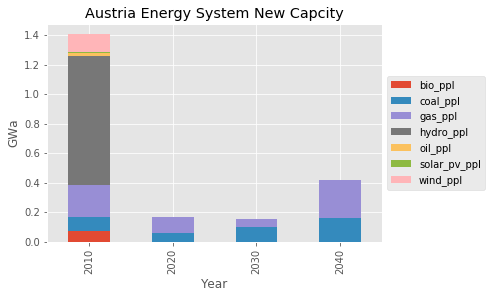

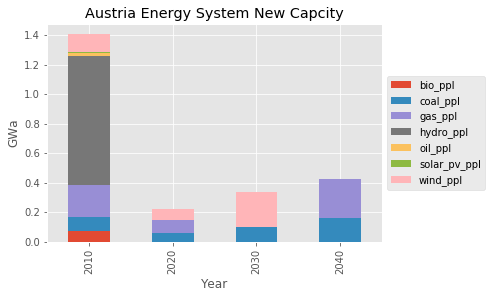

In [5]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_new_capacity(baseyear=True, subset=plants)
    Plots(scenario, country).plot_new_capacity(baseyear=True, subset=plants)

# Demand-Side Learning

This model does not use `cfl`s in the basline because they are too expensive. What happens if their cost reduces with time?

In [6]:
new_scen = 'cheap_cfls'

costs = np.array([1.0, 0.6, 0.3, 0.1])
inv_cost = pd.DataFrame({
        'node_loc': country,
        'year_vtg': horizon,
        'technology': 'cfl',
        'value': 900 * costs * 1e6,
        'unit': 'USD/GWa',
})

with make_scenario(mp, country, name, base_scen, new_scen) as scenario:
    scenario.add_par('inv_cost', inv_cost)

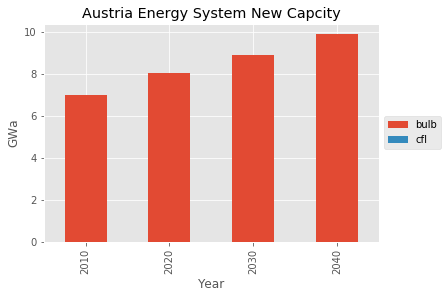

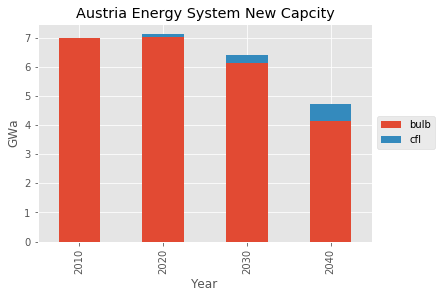

In [7]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_new_capacity(baseyear=True, subset=lights)
    Plots(scenario, country).plot_new_capacity(baseyear=True, subset=lights)

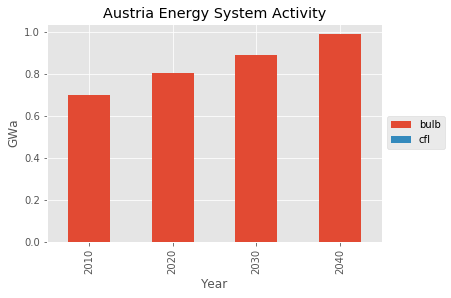

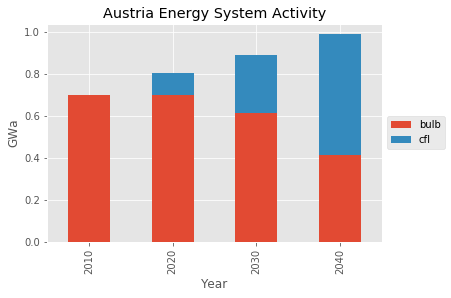

In [8]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_activity(baseyear=True, subset=lights)
    Plots(scenario, country).plot_activity(baseyear=True, subset=lights)

# Exercise: Economic Assumptions

What is the effect of assuming a different interest rate? What if it is higher than the baseline? Lower? How does this affect prices?

In [9]:
with read_scenario(mp, name, base_scen) as base:
    print(base.par('interestrate'))

  unit  value  year
0    %   0.05  2010
1    %   0.05  2020
2    %   0.05  2030
3    %   0.05  2040


In [10]:
new_scen = 'interest_rate_.1'

with make_scenario(mp, country, name, base_scen, new_scen) as scenario:
    scenario.add_par("interestrate", horizon, value=.1, unit='%')

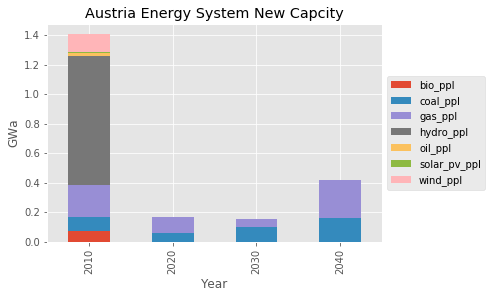

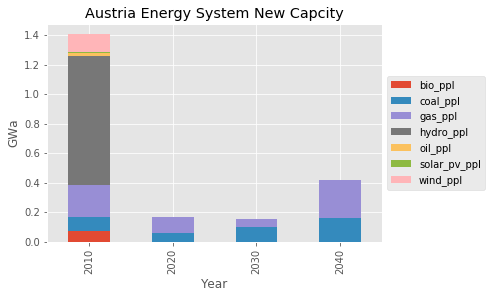

In [11]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_new_capacity(baseyear=True, subset=plants)
    Plots(scenario, country).plot_new_capacity(baseyear=True, subset=plants)

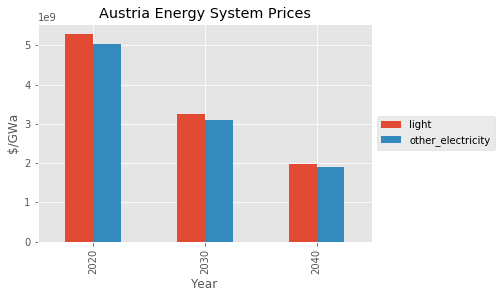

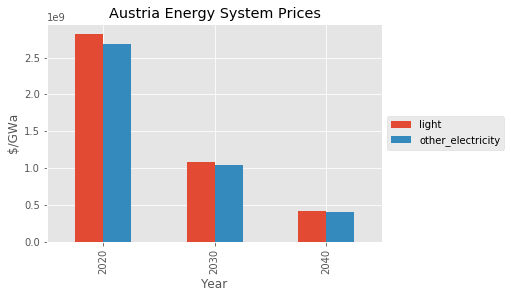

In [12]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_prices(baseyear=False, subset=['light', 'other_electricity'])
    Plots(scenario, country).plot_prices(baseyear=False, subset=['light', 'other_electricity'])

# Exercise: Carbon Tax

What effect does a carbon tax have on the system? What if it is phased in over time? What is the effect on energy prices?

Hints:

- what emissions parameters are available from `scenario.par_list()`?
- find out which fields are required using `scenario.idx_names(par_name)`
- carbon taxes are normally provided in units of USD/tCO2
- a normal proposed carbon tax is ~30 USD/tCO2

In [13]:
with read_scenario(mp, name, base_scen) as base:
    print([par for par in base.par_list() if 'emission' in par])

[u'emission_factor', u'historical_emission', u'emission_scaling', u'bound_emission', u'tax_emission', u'land_emission']


In [14]:
with read_scenario(mp, name, base_scen) as base:
    print(base.idx_names('tax_emission'))

[u'node' u'type_emission' u'type_tec' u'type_year']


In [15]:
new_scen = 'carbon_tax'

taxes = pd.DataFrame({
        'node': country,
        'type_emission': 'GHGs',
        'type_year': horizon,
        'type_tec': 'all',
        'value': np.array([0.0, 20.0, 30., 40.]),
        'unit': 'USD/tCO2', 
})

with make_scenario(mp, country, name, base_scen, new_scen) as scenario:
    scenario.add_par('tax_emission', taxes)

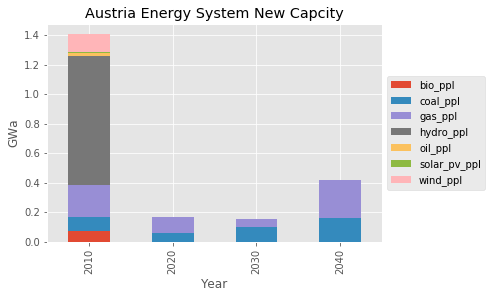

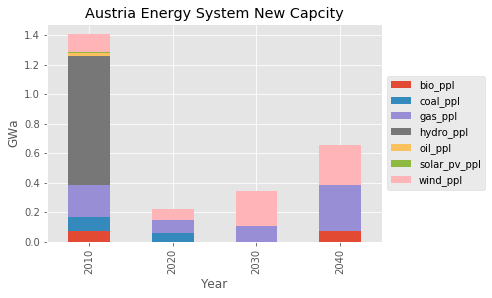

In [16]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_new_capacity(baseyear=True, subset=plants)
    Plots(scenario, country).plot_new_capacity(baseyear=True, subset=plants)

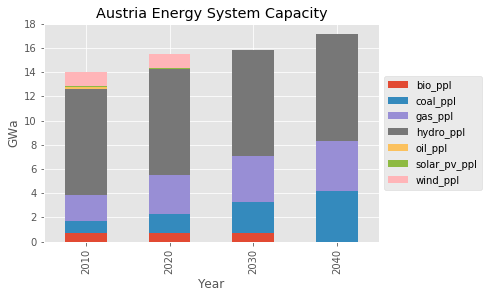

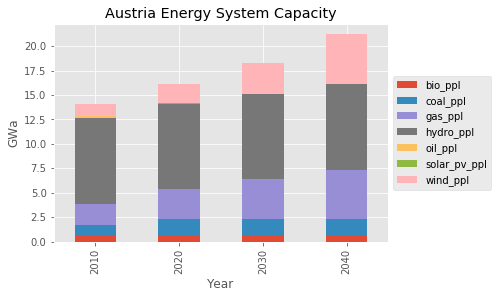

In [17]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_capacity(baseyear=True, subset=plants)
    Plots(scenario, country).plot_capacity(baseyear=True, subset=plants)

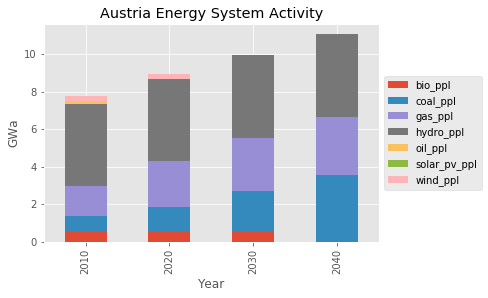

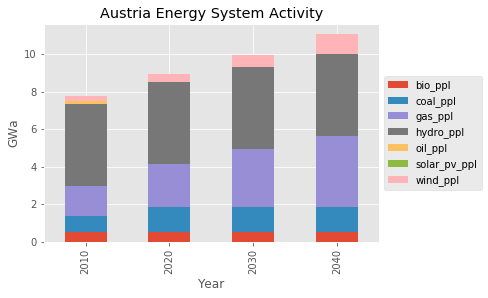

In [18]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_activity(baseyear=True, subset=plants)
    Plots(scenario, country).plot_activity(baseyear=True, subset=plants)

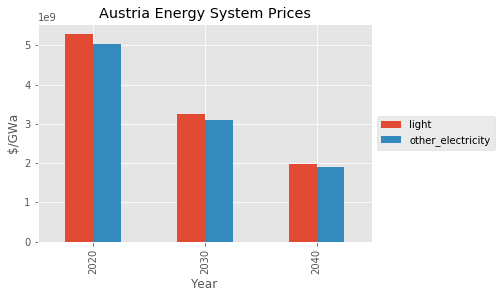

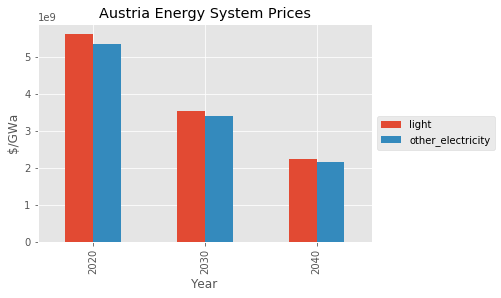

In [19]:
with read_scenario(mp, name, new_scen) as scenario, read_scenario(mp, name, base_scen) as base:
    Plots(base, country).plot_prices(baseyear=False, subset=['light', 'other_electricity'])
    Plots(scenario, country).plot_prices(baseyear=False, subset=['light', 'other_electricity'])